In [138]:
import random
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from functools import cache
import numpy as np
from sage.matroids.advanced import *
import bisect

# Random Matroid Generation

In [227]:
class RandomMatroid:
    def __init__(self, n):
        self.n = n
    
    # If not overriden, returns a random k-uniform matroid, where k is also uniform
    # between 1 and the universe size
    def rand_matroid(self):
        return matroids.Uniform(3, self.n)
    
    def gen(self, num_matroids):
        for _ in range(num_matroids):
            yield self.rand_matroid()

In [140]:
class GraphicRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        
    def rand_matroid(self):
        G = graphs.RandomGNM(random.randint(math.ceil((1+math.sqrt(1+8*self.n))/2), self.n), self.n)
        edges = [(e[0], e[1], i) for i, e in enumerate(G.edges())]
        return Matroid(graph=edges)

In [141]:
class LinearRandomMatroid(RandomMatroid):
    # Dependence probability p refers to the probability that a newly generated element will be 
    # independent from all previous elements. If the element isn't independent from all previous 
    # elements, then it will be chosen to be a random integer linear combination of a uniform 
    # subset of the previously generated elements
    #
    # All linear matroids will be over a finite field of the given order. To simulate real numbers,
    # make the order big compared to n
    def __init__(self, n, order=100, p=[0, 1]):
        super().__init__(n)
        self.order = order
        self.p = p
    
    # return one random linear matroid
    def rand_matroid(self):
        p = random.uniform(*self.p)
        first_vector = [random.randint(0, self.order - 1) for j in range(self.n)]
        matrix = [first_vector]
        for i in range(1, self.n):
            if random.random() < p:
                # generate a uniform random subset of [1, ..., i - 1]
                index_set = []
                for j in range(i):
                    if random.random() < 0.5: index_set.append(j)
                        
                if len(index_set) == 0: vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                else:
                    vector = np.array([0 for j in range(self.n)])
                    for j in index_set:
                        coef = random.randint(1, self.order - 1)
                        to_add = np.array(matrix[j])
                        vector += to_add * coef
                        vector = vector % self.order
                        
                    vector = list(vector)
                        
            else: 
                vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                
            matrix.append(vector)

        l = LinearMatroid(Matrix(GF(self.order), self.n, self.n, matrix).transpose())
        if verbose: print(l.rank())
        return l

In [142]:
class LinearRandomMatroid2(RandomMatroid):
    # Dependence probability p refers to the probability that a newly generated element will be 
    # independent from all previous elements. If the element isn't independent from all previous 
    # elements, then it will be chosen to be a random integer linear combination of a uniform 
    # subset of the previously generated elements
    #
    # All linear matroids will be over a finite field of the given order. To simulate real numbers,
    # make the order big compared to n
    def __init__(self, n, order=100, p=[0, 1]):
        super().__init__(n)
        self.order = order
        self.p = random.uniform(*p)
    
    # return one random linear matroid
    def rand_matroid(self):
        first_vector = [random.randint(0, self.order - 1) for j in range(self.n)]
        matrix = [first_vector]
        for i in range(1, self.n):
            if random.random() < self.p:
                # generate a uniform random subset of [1, ..., i - 1]
                index_set = []
                for j in range(i):
                    if random.random() < 0.37: index_set.append(j)
                        
                if len(index_set) == 0: vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                else:
                    vector = np.array([0 for j in range(self.n)])
                    for j in index_set:
                        coef = random.randint(1, self.order - 1)
                        to_add = np.array(matrix[j])
                        vector += to_add * coef
                        vector = vector % self.order
                        
                    vector = list(vector)
                        
            else: 
                vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                
            matrix.append(vector)

        l = LinearMatroid(Matrix(GF(self.order), self.n, self.n, matrix).transpose())
        if verbose: print(l.rank())
        return l

In [143]:
class TransversalMatroid:
    # a = Number of nodes on the left side, a = number of nodes on the right side
    # p = likelihood of a certain edge from some vertex on left to some vertex on right appearing
    def __init__(self, a, b, p):
        self.a = a; self.b = b; self.p = p
        
        self.A = [i for i in range(0, self.a)]
        self.B = [i for i in range(self.a, self.a + self.b)]
        self.source = -1
        self.sink = self.a + self.b
        self.adjacency = {vertex: [] for vertex in range(self.sink + 1)}
        self.adjacency[self.source] = [x for x in self.A]
        
        # Initialize flow-network that will be used to check if perfect matchings exist
        for v2 in self.B: self.adjacency[v2].append(self.sink)
        
        for v1 in self.A:
            for v2 in self.B:
                if random.random() < p: self.adjacency[v1].append(v2)
                    
        self.G = DiGraph(self.adjacency)
        #self.G.plot().show()
        
        for edge in self.G.edge_boundary(self.A):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1)
            
        for edge in self.G.edge_boundary(self.B):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1)
            
        self.n = a

    # Important: to make use of the cache, s needs to be immutable, e.g. a frozenset
    @cache
    def is_independent(self, s):
        for edge in self.G.edge_boundary([self.source]):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1 if v in s else 0)
        
        flow = self.G.flow(self.source, self.sink, use_edge_labels=True)
        assert flow <= len(s)
        return flow == len(s)
    
    # Finds a max-weight basis of X (that is a subset of 0, ..., n - 1)
    # weights should be a dictionary with key in X and value equivalent to weight of key
    def max_weight_independent(self, X=None, weights=None):
        # Use the greedy algorithm
        order = sorted(X, key=lambda item: weights[item], reverse=True)
        
        current = set()
        for e in order:
            current.add(e)
            if not self.is_independent(frozenset(current)):
                current.remove(e)

        return current
    
    # Return the span of X
    def closure(self, X):
        basis = self.max_weight_independent(X, {x: 0 for x in X})
        
        span = set()
        for i in range(self.n):
            if i in basis: span.add(i)
            else:
                basis.add(i)
                if not self.is_independent(frozenset(basis)): span.add(i)
                basis.remove(i)
                
        return span
    
    def size(self):
        return self.n

In [144]:
class TransversalRandomMatroid(RandomMatroid):
    # a = Number of nodes on the left side, a = number of nodes on the right side
    # p = likelihood of a certain edge from some vertex on left to some vertex on right appearing
    def __init__(self, a=10, b=10, p=0.5):
        super().__init__(a)
        self.a = a
        self.b = b
        self.p = p
    
    # return one random transversal matroid
    def rand_matroid(self):
        return TransversalMatroid(self.a, self.b, self.p)

In [145]:
class GeneralRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        self.U = frozenset(range(n))
    
    def _isContained(self, AandB, Fr):
        if len(AandB) == 0: return True
        for C in Fr:
            if AandB.issubset(C): return True
        return False
    
    def rand_matroid(self):
        r = 0
        F = [set(frozenset())]
        while self.U not in F[r]:
            # generate covers
            F_next = set(frozenset())
            if r == 0:
                for a in self.U:
                    F_next.add(frozenset([a]))
            else:
                for A in F[r]:
                    for a in self.U - A:
                        x = set(A)
                        x.add(a)
                        F_next.add(frozenset(x))

            #enlarge
            if r != 0:
                # adjust the number of times this loop is performed to generate different matroids
                for _ in range(random.randint(0, self.n//2)):
                    A = set(random.choice(list(F_next)))
                    F_next.remove(A)
                    if len(list(self.U-A)) != 0:
                        A.add(random.choice(list(self.U-A)))
                    F_next.add(frozenset(A))

            # superpose
            isContained = False
            while not isContained:
                isContained = True
                not_contained = []
                for A in F_next:
                    for B in F_next:
                        if A == B: continue
                        if not self._isContained(A.intersection(B), F[r]): 
                            not_contained.append((A, B))
                            isContained = False
                for AB in not_contained:
                    A, B = AB
                    if A in F_next and B in F_next:
                        F_next.remove(A)
                        F_next.remove(B)
                        F_next.add(A.union(B))
            F.append(F_next)
            r += 1
    
        closed_sets = []
        for rank, X in enumerate(F):
            for Y in X:
                closed_sets.append((rank, Y))

        return Matroid(self.U, circuit_closures = closed_sets)

# Test Suite for Naive Virtual Algorithm

## Algorithm Implementation

In [244]:
# Import any algorithm implementations here
class FreeOrderMatroidAlgo:
    def __init__(self, matroid, weights):
        assert matroid.size() == len(weights)

        self.matroid = matroid
        self.weights = weights

class Conjecture(FreeOrderMatroidAlgo):
    def __init__(self, matroid, weights, sample_prob, verbose=False):
        super().__init__(matroid, weights)
        self.verbose = verbose
        
        # Sample S
        S = []
        self.P = set()
        for i in range(self.matroid.size()):
            if random.random() < sample_prob: 
                S.append((i, self.weights[i]))
            else: self.P.add(i)
                
        self.top_k = sorted([(weight_i, True) for i, weight_i in S])

        self.P = frozenset(self.P)
        S = dict(S)
        if self.verbose: print(f'{S = }')
        self.X = self.matroid.max_weight_independent(X=set(S.keys()), weights=S) # max-weight basis of S
        self.X = sorted(list(self.X), key=lambda i: self.weights[i], reverse=True)
        
        self.k = self.matroid.rank()

    def run_trial(self):
        cache(self.matroid.is_independent)
        
        total = 0
        remaining = set(self.P) # which elements haven't been seen yet
        A = frozenset() # store the answer

        Xset = set()
        for i, basis_elem in enumerate(self.X):
            # Check which elements in remaining are dependent
            Xset.add(basis_elem)
            candidates = []
            #print(candidates)
            for element in remaining:
                Xset.add(element)
                if not self.matroid.is_independent(frozenset(Xset)): candidates.append(element)
                Xset.remove(element)
            random.shuffle(candidates)
            
            if self.verbose: print(f'{candidates = }')
            for y in candidates:
                remaining.remove(y)
                
                top_i_weight, top_i_from_sample = self.top_k[len(self.top_k) - i - 1]
                
                if (self.weights[y] > top_i_weight) and (top_i_from_sample):
                    if self.matroid.is_independent(A.union(frozenset([y]))): 
                        A = A.union(frozenset([y]))
                        total += self.weights[y]
                        if self.verbose: print(f'{y = }')
                    
                bisect.insort(self.top_k, (self.weights[y], False))

        remaining = list(remaining)
        if self.verbose: print(f'{remaining = }')
        random.shuffle(remaining)
        #print(f'{remaining = }')
        for y in remaining:
            
            #print(self.top_k)
            
            if len(self.top_k) >= self.k:
                top_k_weight, top_k_from_sample = self.top_k[len(self.top_k) - self.k]
                
                if not top_k_from_sample:
                    bisect.insort(self.top_k, (self.weights[y], False))
                    continue
                
            if self.matroid.is_independent(A.union(frozenset([y]))): 
                A = A.union(frozenset([y]))
                total += self.weights[y]
            
            bisect.insort(self.top_k, (self.weights[y], False))

        return total, A

## Experiment Setup

In [147]:
# algo is assumed to be a FreeOrderMatroidAlgo. Returns averaged payoff over all trials
# weights will be a list of values of each item
def run_trials(num_trials, matroid, weights, verbose = False):
    sum = 0
    total_counts = defaultdict(lambda: 0)
    for _ in range(num_trials):
        algo = Conjecture(matroid, weights, exp(-1), verbose)
        weight, included = algo.run_trial()
        sum += weight
        if verbose: print(f'{included = }')
        for element in included: total_counts[element] += 1

    for key in total_counts: total_counts[key] = float(total_counts[key]) / num_trials
    return float(sum / num_trials), total_counts

In [ ]:
def run_experiment(M, num_trials, weights = None, verbose = False):
    if weights is None: weights = [random.uniform(0, 1) for i in range(M.size())]

    start_time = time.time()
    val, freqs = run_trials(num_trials, M, weights, verbose)
    end_time = time.time()
    
    if verbose: print(f"Time to run {num_trials} trials is ", end_time - start_time)

    opt_indices = M.max_weight_independent(X=set(range(M.size())), weights = dict([(i, weight) for i, weight in enumerate(weights)]))
    opt_val = 0
    ratios = []
    
    for opt_index in opt_indices:
        ratios.append(freqs[opt_index])
        #if (freqs[opt_index] < exp(-1)):
            #print("Less than 1/e when ", M, opt_index)

    if verbose: print(ratios)
    return min(ratios)

In [149]:
def evaluate(rand_matroid, num_matroids, num_trials):
    results = []
    for i, M in enumerate(rand_matroid.gen(num_matroids), 1):
        start = time.time()
        results.append(run_experiment(M, num_trials))
        end = time.time()
        print(f'Matroid {i}/{num_matroids} completed in {round(end - start, 2)}s')
    return results

In [150]:
def plot(results, fname=None):
    bins = []
    for x in range(int(min(results)/((1/30)*float(exp(-1)))), int(max(results)/((1/30)*float(exp(-1))))+1):
        bins.append(x*(1/30)*float(exp(-1)))
    plt.hist(results, bins = bins, density=True)
    plt.axvline(x=float(exp(-1)), color = 'r', linestyle='dashed')
    plt.xlabel('Minimum Ratio of Optimal Secretaries', fontsize=16)
    plt.ylabel('Density (%)', fontsize=16)
    plt.tight_layout()
    if fname: plt.savefig(fname)
    plt.show()

## Evaluation of Algorithm

In [219]:
# Experiment 1: 100 graphic matroids, size 101
random.seed(int(1001))
results1 = evaluate(GraphicRandomMatroid(n=31), num_matroids=3, num_trials=100)

{2: 0.9446706704145225, 3: 0.5555947490222188, 5: 0.1602232933542107, 6: 0.7219800455456423, 7: 0.564217937357919, 10: 0.1990814030751068, 13: 0.9493316241240977, 17: 0.6128298695169923, 23: 0.5638624420593042, 25: 0.9029388383525211}
[(0.1602232933542107, True), (0.1990814030751068, True), (0.5555947490222188, True), (0.5638624420593042, True), (0.564217937357919, True), (0.6128298695169923, True), (0.7219800455456423, True), (0.9029388383525211, True), (0.9446706704145225, True), (0.9493316241240977, True)]
{4: 0.3773075922272805, 6: 0.7219800455456423, 13: 0.9493316241240977, 14: 0.7468312600416872, 17: 0.6128298695169923, 20: 0.733578554503842, 21: 0.6115342224117988, 22: 0.14864654853188664, 25: 0.9029388383525211, 27: 0.09965750472760093}
[(0.09965750472760093, True), (0.14864654853188664, True), (0.3773075922272805, True), (0.6115342224117988, True), (0.6128298695169923, True), (0.7219800455456423, True), (0.733578554503842, True), (0.7468312600416872, True), (0.9029388383525211

{6: 0.7219800455456423, 7: 0.564217937357919, 10: 0.1990814030751068, 12: 0.03063867045259472, 14: 0.7468312600416872, 20: 0.733578554503842, 24: 0.100995835932288, 25: 0.9029388383525211, 27: 0.09965750472760093, 29: 0.43455840343876917}
[(0.03063867045259472, True), (0.09965750472760093, True), (0.100995835932288, True), (0.1990814030751068, True), (0.43455840343876917, True), (0.564217937357919, True), (0.7219800455456423, True), (0.733578554503842, True), (0.7468312600416872, True), (0.9029388383525211, True)]
{1: 0.19803599910962377, 7: 0.564217937357919, 10: 0.1990814030751068, 17: 0.6128298695169923, 20: 0.733578554503842, 21: 0.6115342224117988, 23: 0.5638624420593042, 26: 0.6869682679293944, 27: 0.09965750472760093}
[(0.09965750472760093, True), (0.19803599910962377, True), (0.1990814030751068, True), (0.5638624420593042, True), (0.564217937357919, True), (0.6115342224117988, True), (0.6128298695169923, True), (0.6869682679293944, True), (0.733578554503842, True)]
{2: 0.944670

{1: 0.19803599910962377, 2: 0.9446706704145225, 11: 0.8792268265092663, 13: 0.9493316241240977, 14: 0.7468312600416872, 15: 0.49310405340000263, 17: 0.6128298695169923, 18: 0.9371499209667907, 23: 0.5638624420593042, 24: 0.100995835932288, 28: 0.881875181598935}
[(0.100995835932288, True), (0.19803599910962377, True), (0.49310405340000263, True), (0.5638624420593042, True), (0.6128298695169923, True), (0.7468312600416872, True), (0.8792268265092663, True), (0.881875181598935, True), (0.9371499209667907, True), (0.9446706704145225, True), (0.9493316241240977, True)]
{0: 0.7606404107826931, 1: 0.19803599910962377, 4: 0.3773075922272805, 5: 0.1602232933542107, 6: 0.7219800455456423, 7: 0.564217937357919, 8: 0.773674960441326, 12: 0.03063867045259472, 15: 0.49310405340000263, 21: 0.6115342224117988, 24: 0.100995835932288, 26: 0.6869682679293944, 27: 0.09965750472760093, 30: 0.9131271919256607}
[(0.03063867045259472, True), (0.09965750472760093, True), (0.100995835932288, True), (0.16022329

{0: 0.8441824787244566, 1: 0.6691000224675955, 2: 0.10847014562717694, 7: 0.4767023217349, 8: 0.3916607062858072, 9: 0.7690536396056176, 13: 0.013802211971427392, 16: 0.7949631477180845, 20: 0.9896571121376914, 23: 0.23509503968604895, 26: 0.35864203219468704, 27: 0.5859978063743055, 28: 0.4144615521629651, 29: 0.7488634314389183, 30: 0.39665811771143344}
[(0.013802211971427392, True), (0.10847014562717694, True), (0.23509503968604895, True), (0.35864203219468704, True), (0.3916607062858072, True), (0.39665811771143344, True), (0.4144615521629651, True), (0.4767023217349, True), (0.5859978063743055, True), (0.6691000224675955, True), (0.7488634314389183, True), (0.7690536396056176, True), (0.7949631477180845, True), (0.8441824787244566, True), (0.9896571121376914, True)]
{1: 0.6691000224675955, 2: 0.10847014562717694, 8: 0.3916607062858072, 9: 0.7690536396056176, 15: 0.4597867138387849, 17: 0.22234534461703215, 20: 0.9896571121376914, 23: 0.23509503968604895, 24: 0.27512766102577935, 2

{2: 0.10847014562717694, 3: 0.8324034583733682, 5: 0.7318534022723602, 7: 0.4767023217349, 8: 0.3916607062858072, 14: 0.5679957482890622, 17: 0.22234534461703215, 18: 0.5326054311578211, 19: 0.49721371493504674, 21: 0.307826897343785, 25: 0.16544825205040692, 28: 0.4144615521629651, 30: 0.39665811771143344}
[(0.10847014562717694, True), (0.16544825205040692, True), (0.22234534461703215, True), (0.307826897343785, True), (0.3916607062858072, True), (0.39665811771143344, True), (0.4144615521629651, True), (0.4767023217349, True), (0.49721371493504674, True), (0.5326054311578211, True), (0.5679957482890622, True), (0.7318534022723602, True), (0.8324034583733682, True)]
{1: 0.6691000224675955, 2: 0.10847014562717694, 4: 0.0009535329463230546, 8: 0.3916607062858072, 11: 0.6493823627809934, 15: 0.4597867138387849, 20: 0.9896571121376914, 23: 0.23509503968604895, 25: 0.16544825205040692, 26: 0.35864203219468704, 28: 0.4144615521629651}
[(0.0009535329463230546, True), (0.10847014562717694, Tru

{3: 0.8324034583733682, 6: 0.27356065631130744, 7: 0.4767023217349, 13: 0.013802211971427392, 14: 0.5679957482890622, 16: 0.7949631477180845, 18: 0.5326054311578211, 21: 0.307826897343785, 25: 0.16544825205040692, 26: 0.35864203219468704}
[(0.013802211971427392, True), (0.16544825205040692, True), (0.27356065631130744, True), (0.307826897343785, True), (0.35864203219468704, True), (0.4767023217349, True), (0.5326054311578211, True), (0.5679957482890622, True), (0.7949631477180845, True), (0.8324034583733682, True)]
{4: 0.0009535329463230546, 6: 0.27356065631130744, 13: 0.013802211971427392, 15: 0.4597867138387849, 18: 0.5326054311578211, 21: 0.307826897343785, 23: 0.23509503968604895, 26: 0.35864203219468704, 29: 0.7488634314389183}
[(0.0009535329463230546, True), (0.013802211971427392, True), (0.23509503968604895, True), (0.27356065631130744, True), (0.307826897343785, True), (0.35864203219468704, True), (0.4597867138387849, True), (0.5326054311578211, True), (0.7488634314389183, True

{0: 0.8441824787244566, 1: 0.6691000224675955, 6: 0.27356065631130744, 9: 0.7690536396056176, 10: 0.4093350376202295, 16: 0.7949631477180845, 18: 0.5326054311578211, 19: 0.49721371493504674}
[(0.27356065631130744, True), (0.4093350376202295, True), (0.49721371493504674, True), (0.5326054311578211, True), (0.6691000224675955, True), (0.7690536396056176, True), (0.7949631477180845, True), (0.8441824787244566, True)]
{0: 0.8441824787244566, 10: 0.4093350376202295, 11: 0.6493823627809934, 18: 0.5326054311578211, 19: 0.49721371493504674, 24: 0.27512766102577935, 27: 0.5859978063743055, 30: 0.39665811771143344}
[(0.27512766102577935, True), (0.39665811771143344, True), (0.4093350376202295, True), (0.49721371493504674, True), (0.5326054311578211, True), (0.5859978063743055, True), (0.6493823627809934, True), (0.8441824787244566, True)]
Matroid 2/3 completed in 0.72s
{0: 0.26007590296830996, 1: 0.025108764960234065, 7: 0.28373087717599244, 10: 0.14396091220304563, 11: 0.1325276748535804, 12: 0

{2: 0.7794248550875847, 5: 0.39078214814075685, 17: 0.6765417509367857, 19: 0.9249063847274569, 22: 0.9749707911876626, 24: 0.4357194859005151, 25: 0.10101626037730527, 26: 0.56454155474231}
[(0.10101626037730527, True), (0.39078214814075685, True), (0.4357194859005151, True), (0.56454155474231, True), (0.6765417509367857, True), (0.7794248550875847, True), (0.9249063847274569, True), (0.9749707911876626, True)]
{1: 0.025108764960234065, 5: 0.39078214814075685, 7: 0.28373087717599244, 8: 0.32698966803710505, 9: 0.4701405544538405, 10: 0.14396091220304563, 11: 0.1325276748535804, 12: 0.011252934884437349, 13: 0.7865606953380453, 20: 0.062396516442944305, 21: 0.6133823714057963, 23: 0.01344852659354323, 24: 0.4357194859005151, 28: 0.13443058195138624}
[(0.011252934884437349, True), (0.01344852659354323, True), (0.025108764960234065, True), (0.062396516442944305, True), (0.1325276748535804, True), (0.13443058195138624, True), (0.14396091220304563, True), (0.28373087717599244, True), (0.32

{5: 0.39078214814075685, 7: 0.28373087717599244, 14: 0.23774641022719845, 17: 0.6765417509367857, 20: 0.062396516442944305, 26: 0.56454155474231}
[(0.062396516442944305, True), (0.23774641022719845, True), (0.28373087717599244, True), (0.39078214814075685, True), (0.56454155474231, True), (0.6765417509367857, True)]
{0: 0.26007590296830996, 4: 0.39053583201825537, 6: 0.4750813497418306, 7: 0.28373087717599244, 8: 0.32698966803710505, 11: 0.1325276748535804, 13: 0.7865606953380453, 15: 0.3025060682498595, 18: 0.1060341936321686, 26: 0.56454155474231, 27: 0.12736458098960068}
[(0.1060341936321686, True), (0.12736458098960068, True), (0.1325276748535804, True), (0.26007590296830996, True), (0.28373087717599244, True), (0.3025060682498595, True), (0.32698966803710505, True), (0.39053583201825537, True), (0.4750813497418306, True), (0.56454155474231, True), (0.7865606953380453, True)]
{3: 0.06535576930747011, 5: 0.39078214814075685, 6: 0.4750813497418306, 7: 0.28373087717599244, 8: 0.326989

{0: 0.26007590296830996, 3: 0.06535576930747011, 8: 0.32698966803710505, 15: 0.3025060682498595, 16: 0.06213845985132105, 17: 0.6765417509367857, 18: 0.1060341936321686, 19: 0.9249063847274569, 21: 0.6133823714057963, 22: 0.9749707911876626, 23: 0.01344852659354323, 24: 0.4357194859005151, 25: 0.10101626037730527, 27: 0.12736458098960068, 29: 0.35085687318364533}
[(0.01344852659354323, True), (0.06213845985132105, True), (0.06535576930747011, True), (0.10101626037730527, True), (0.1060341936321686, True), (0.12736458098960068, True), (0.26007590296830996, True), (0.3025060682498595, True), (0.32698966803710505, True), (0.35085687318364533, True), (0.4357194859005151, True), (0.6133823714057963, True), (0.6765417509367857, True), (0.9249063847274569, True), (0.9749707911876626, True)]
{6: 0.4750813497418306, 7: 0.28373087717599244, 8: 0.32698966803710505, 10: 0.14396091220304563, 14: 0.23774641022719845, 16: 0.06213845985132105, 22: 0.9749707911876626, 26: 0.56454155474231}
[(0.06213845

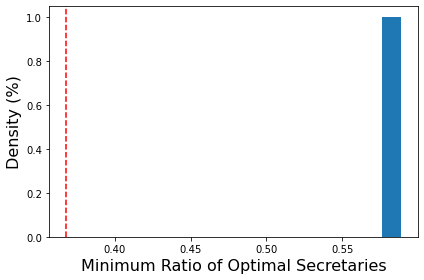

In [196]:
plot([0.586, 0.599, 0.595, 0.599, 0.589])

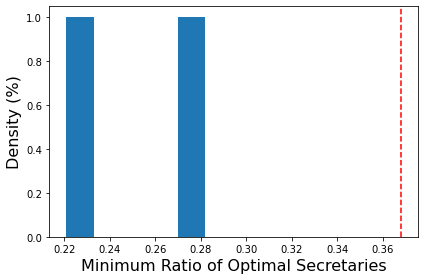

[0.23, 0.29, 0.28]


In [220]:
plot(results1)
print(results1)

In [216]:
# Experiment 2: 5 Transversal Matroids on a bipartite graph with nodes on left = 25, 
# nodes on right = 25, and edge inclusion probability 0.2
random.seed(int(1002))
results2 = evaluate(TransversalRandomMatroid(25, 25, 0.2), num_matroids=5, num_trials=1000)

Matroid 1/5 completed in 179.54s
Matroid 2/5 completed in 191.72s
Matroid 3/5 completed in 186.53s
Matroid 4/5 completed in 197.52s
Matroid 5/5 completed in 205.53s


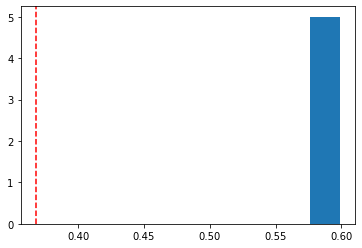

[0.586, 0.599, 0.595, 0.599, 0.589]


In [217]:
plot(results2)
print(results2)

In [ ]:
# Experiment 3: 5 Transversal Matroids on a bipartite graph with nodes on left = 25, 
# nodes on right = 25, and edge inclusion probability 0.5
random.seed(int(1004))
results3 = evaluate(TransversalRandomMatroid(50, 25, 0.5), num_matroids=5, num_trials=1000)

Matroid 1/5 completed in 9119.76s
Matroid 2/5 completed in 3773.59s
Matroid 3/5 completed in 4677.09s


In [ ]:
plot(results3)
print(results3)

In [148]:
# Experiment 4: 5 Transversal Matroids on a bipartite graph with nodes on left = 50, 
# nodes on right = 25, and edge inclusion probability 0.3
random.seed(int(1004))
results4 = evaluate(TransversalRandomMatroid(50, 25, 0.3), num_matroids=5, num_trials=1000)

[1.0, 0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0]
Matroid 1/5 completed in 3.27s
[0, 0, 0, 0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0, 0, 0, 0, 0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0]
Matroid 2/5 completed in 3.04s
[1.0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 0]
Matroid 3/5 completed in 2.38s
[0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0]
Matroid 4/5 completed in 3.01s
[0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0]
Matroid 5/5 completed in 2.96s


In [ ]:
plot(results4)
print(results4)

In [ ]:
# Experiment 5: 5 Transversal Matroids on a bipartite graph with nodes on left = 25, 
# nodes on right = 50, and edge inclusion probability 0.5
random.seed(int(1005))
results5 = evaluate(TransversalRandomMatroid(50, 25, 0.3), num_matroids=5, num_trials=1000)

In [ ]:
plot(results5)
print(results5)

In [ ]:
# Plot all 
plot(results2 + results3 + results4 + results5)

In [225]:
# Experiment 6: 100 Random Matroids with universe size = 13 (Note that these aren't actually
# uniformly at random chosen from all size-13 matroids; see Knuth's algorithm)

random.seed(int(1006))
results6 = evaluate(GeneralRandomMatroid(13), num_matroids=1, num_trials=1)

[0.37, 0.414, 0.143, 0.284, 0.173]
Matroid 1/10 completed in 3.01s
[0.326, 0.35, 0.293, 0.315, 0.328, 0.34]
Matroid 2/10 completed in 2.81s
[0.365, 0.345, 0.348, 0.363]
Matroid 3/10 completed in 2.38s
[0.388, 0.393, 0.23, 0.219]
Matroid 4/10 completed in 2.04s
[0.405, 0.251, 0.291, 0.367, 0.262]
Matroid 5/10 completed in 2.29s
[0.324, 0.335, 0.389, 0.34, 0.375]
Matroid 6/10 completed in 3.81s
[0.281, 0.405, 0.36, 0.39, 0.361, 0.352]
Matroid 7/10 completed in 4.41s
[0.339, 0.337, 0.345, 0.349]
Matroid 8/10 completed in 2.75s
[0.346, 0.355, 0.253, 0.352, 0.269]
Matroid 9/10 completed in 2.14s
[0.316, 0.366, 0.38, 0.378, 0.362, 0.346]
Matroid 10/10 completed in 3.69s


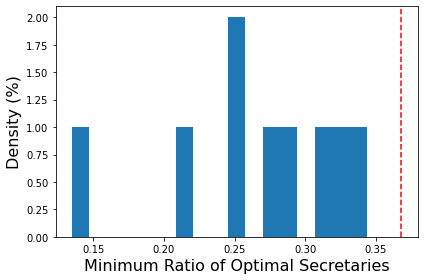

[0.143, 0.293, 0.345, 0.219, 0.251, 0.324, 0.281, 0.337, 0.253, 0.316]


In [223]:
plot(results6)
print(results6)

In [245]:
# Experiment 7: 100 Random Uniform Matroids with universe size = 200 (rank is also random)
random.seed(int(1007))
results7 = evaluate(RandomMatroid(100), num_matroids=5, num_trials=1000)

[0.376, 0.364, 0.384]
Matroid 1/5 completed in 11.77s
[0.391, 0.376, 0.363]
Matroid 2/5 completed in 11.54s
[0.367, 0.35, 0.368]
Matroid 3/5 completed in 11.58s
[0.35, 0.415, 0.352]
Matroid 4/5 completed in 11.55s
[0.349, 0.345, 0.377]
Matroid 5/5 completed in 11.52s


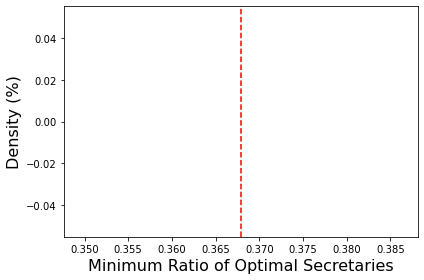

[0.364, 0.363]


In [241]:
plot(results7)
print(results7)

In [51]:
# Experiment 8: 20 random linear matroids in a finite field of order 563 with rank (somewhat)
# uniformly distributed between 1 and universe size
random.seed(int(1008))
results8 = evaluate(LinearRandomMatroid(50, order=3), num_matroids=3, num_trials=1000)

22
Matroid 1/3 completed in 12.18s
23


KeyboardInterrupt: 

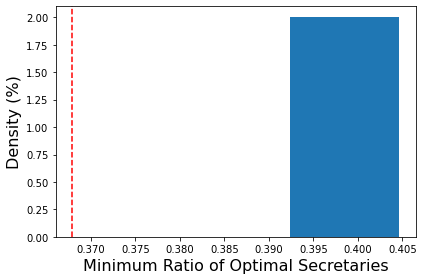

[0.394, 0.405, 0.394]


In [40]:
plot(results8)
print(results8)

In [80]:
# Experiment 8: 20 random linear matroids in a finite field of order 563 with rank (somewhat)
# uniformly distributed between 1 and universe size
random.seed(int(1009))
results9 = evaluate(LinearRandomMatroid(100, order=37, p=[0, 1]), num_matroids=100, num_trials=1000)

78
Matroid 1/100 completed in 73.04s
26
Matroid 2/100 completed in 115.83s
65
Matroid 3/100 completed in 132.24s
7
Matroid 4/100 completed in 16.89s
29
Matroid 5/100 completed in 135.49s
21
Matroid 6/100 completed in 81.43s
39
Matroid 7/100 completed in 172.12s
64
Matroid 8/100 completed in 128.52s
47
Matroid 9/100 completed in 178.17s
52
Matroid 10/100 completed in 187.16s
87
Matroid 11/100 completed in 38.14s
36
Matroid 12/100 completed in 159.83s
6
Matroid 13/100 completed in 15.35s
74
Matroid 14/100 completed in 91.04s
53
Matroid 15/100 completed in 170.98s
57
Matroid 16/100 completed in 175.56s
81
Matroid 17/100 completed in 58.6s
33
Matroid 18/100 completed in 150.88s
40
Matroid 19/100 completed in 193.0s
7
Matroid 20/100 completed in 15.64s
85
Matroid 21/100 completed in 43.05s
80
Matroid 22/100 completed in 66.86s
58
Matroid 23/100 completed in 145.19s
83
Matroid 24/100 completed in 51.63s
10
Matroid 25/100 completed in 23.95s
2
Matroid 26/100 completed in 12.44s
88
Matroid 27/

In [81]:
# Experiment 8: 20 random linear matroids in a finite field of order 563 with rank (somewhat)
# uniformly distributed between 1 and universe size
random.seed(int(1010))
results10 = evaluate(LinearRandomMatroid(100, order=37, p=[0, 1]), num_matroids=100, num_trials=1000)

31
Matroid 1/100 completed in 144.01s
35
Matroid 2/100 completed in 152.79s
49
Matroid 3/100 completed in 208.03s
64
Matroid 4/100 completed in 135.76s
99
Matroid 5/100 completed in 16.16s
70
Matroid 6/100 completed in 94.19s
73
Matroid 7/100 completed in 88.22s
36
Matroid 8/100 completed in 183.27s
94
Matroid 9/100 completed in 20.72s
75
Matroid 10/100 completed in 71.21s
76
Matroid 11/100 completed in 78.53s
48
Matroid 12/100 completed in 163.89s
93
Matroid 13/100 completed in 22.03s
72
Matroid 14/100 completed in 91.19s
21
Matroid 15/100 completed in 96.49s
91
Matroid 16/100 completed in 28.35s
60
Matroid 17/100 completed in 144.93s
39
Matroid 18/100 completed in 182.73s
73
Matroid 19/100 completed in 95.2s
38
Matroid 20/100 completed in 150.53s
86
Matroid 21/100 completed in 38.32s
85
Matroid 22/100 completed in 44.18s
96
Matroid 23/100 completed in 17.92s
7
Matroid 24/100 completed in 22.13s
11
Matroid 25/100 completed in 38.25s
96
Matroid 26/100 completed in 18.54s
24
Matroid 27/

In [82]:
# Experiment 8: 20 random linear matroids in a finite field of order 563 with rank (somewhat)
# uniformly distributed between 1 and universe size
random.seed(int(1011))
results11 = evaluate(LinearRandomMatroid(100, order=37, p=[0, 1]), num_matroids=100, num_trials=1000)

70
Matroid 1/100 completed in 111.56s
70
Matroid 2/100 completed in 93.7s
49
Matroid 3/100 completed in 185.33s
7
Matroid 4/100 completed in 21.37s
53
Matroid 5/100 completed in 165.1s
76
Matroid 6/100 completed in 79.49s
96
Matroid 7/100 completed in 18.5s
88
Matroid 8/100 completed in 35.0s
85
Matroid 9/100 completed in 41.51s
23
Matroid 10/100 completed in 89.43s
91
Matroid 11/100 completed in 23.32s
76
Matroid 12/100 completed in 77.09s
44
Matroid 13/100 completed in 207.27s
61
Matroid 14/100 completed in 149.69s
84
Matroid 15/100 completed in 50.17s
7
Matroid 16/100 completed in 18.35s
21
Matroid 17/100 completed in 82.45s
49
Matroid 18/100 completed in 190.69s
98
Matroid 19/100 completed in 16.67s
68
Matroid 20/100 completed in 116.83s
99
Matroid 21/100 completed in 16.53s
33
Matroid 22/100 completed in 128.3s
57
Matroid 23/100 completed in 146.29s
22
Matroid 24/100 completed in 63.44s
39
Matroid 25/100 completed in 157.02s
51
Matroid 26/100 completed in 178.58s
35
Matroid 27/100

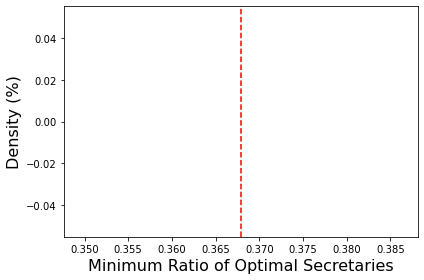

[0.383]


In [77]:
plot(results9)
print(results9)

In [84]:
results = results9.append(results10)
results = results.append(results11)

AttributeError: 'NoneType' object has no attribute 'append'

[0.509, 0.364, 0.439, 0.374, 0.34, 0.365, 0.38, 0.421, 0.396, 0.411, 0.417, 0.361, 0.371, 0.513, 0.408, 0.513, 0.394, 0.366, 0.376, 0.389, 0.602, 0.45, 0.414, 0.442, 0.338, 0.353, 0.383, 0.353, 0.384, 0.378, 0.595, 0.385, 0.396, 0.45, 0.59, 0.407, 0.34, 0.491, 0.381, 0.447, 0.434, 0.368, 0.581, 0.569, 0.344, 0.597, 0.582, 0.408, 0.517, 0.591, 0.373, 0.372, 0.359, 0.46, 0.419, 0.356, 0.393, 0.341, 0.365, 0.375, 0.557, 0.518, 0.413, 0.376, 0.396, 0.459, 0.384, 0.368, 0.374, 0.578, 0.427, 0.445, 0.403, 0.562, 0.359, 0.374, 0.364, 0.452, 0.371, 0.365, 0.398, 0.392, 0.504, 0.365, 0.398, 0.404, 0.426, 0.365, 0.369, 0.411, 0.348, 0.372, 0.333, 0.406, 0.596, 0.59, 0.371, 0.345, 0.354, 0.583, 0.375, 0.372, 0.433, 0.368, 0.594, 0.445, 0.387, 0.364, 0.598, 0.434, 0.42, 0.378, 0.579, 0.533, 0.344, 0.588, 0.412, 0.361, 0.439, 0.387, 0.603, 0.548, 0.597, 0.386, 0.326, 0.594, 0.36, 0.344, 0.418, 0.403, 0.347, 0.345, 0.393, 0.405, 0.378, 0.538, 0.354, 0.598, 0.361, 0.38, 0.396, 0.374, 0.592, 0.341, 0.

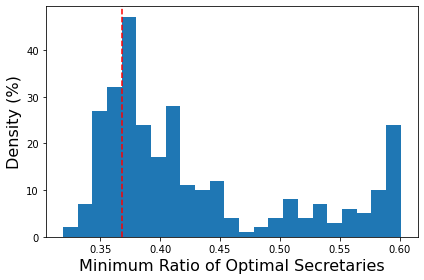

In [93]:
results += results10
results += results11
print(results)
plot(results)

In [94]:
len(results)

300

In [124]:
results = [0.509, 0.364, 0.439, 0.374, 0.34, 0.365, 0.38, 0.421, 0.396, 0.411, 0.417, 0.361, 0.371, 0.513, 0.408, 0.513, 0.394, 0.366, 0.376, 0.389, 0.602, 0.45, 0.414, 0.442, 0.338, 0.353, 0.383, 0.353, 0.384, 0.378, 0.595, 0.385, 0.396, 0.45, 0.59, 0.407, 0.34, 0.491, 0.381, 0.447, 0.434, 0.368, 0.581, 0.569, 0.344, 0.597, 0.582, 0.408, 0.517, 0.591, 0.373, 0.372, 0.359, 0.46, 0.419, 0.356, 0.393, 0.341, 0.365, 0.375, 0.557, 0.518, 0.413, 0.376, 0.396, 0.459, 0.384, 0.368, 0.374, 0.578, 0.427, 0.445, 0.403, 0.562, 0.359, 0.374, 0.364, 0.452, 0.371, 0.365, 0.398, 0.392, 0.504, 0.365, 0.398, 0.404, 0.426, 0.365, 0.369, 0.411, 0.348, 0.372, 0.333, 0.406, 0.596, 0.59, 0.371, 0.345, 0.354, 0.583, 0.375, 0.372, 0.433, 0.368, 0.594, 0.445, 0.387, 0.364, 0.598, 0.434, 0.42, 0.378, 0.579, 0.533, 0.344, 0.588, 0.412, 0.361, 0.439, 0.387, 0.603, 0.548, 0.597, 0.386, 0.326, 0.594, 0.36, 0.344, 0.418, 0.403, 0.347, 0.345, 0.393, 0.405, 0.378, 0.538, 0.354, 0.598, 0.361, 0.38, 0.396, 0.374, 0.592, 0.341, 0.592, 0.572, 0.36, 0.369, 0.416, 0.505, 0.365, 0.415, 0.446, 0.519, 0.536, 0.401, 0.371, 0.501, 0.372, 0.373, 0.529, 0.595, 0.407, 0.346, 0.408, 0.583, 0.367, 0.432, 0.376, 0.39, 0.351, 0.52, 0.354, 0.438, 0.376, 0.347, 0.348, 0.372, 0.382, 0.406, 0.359, 0.373, 0.425, 0.351, 0.392, 0.372, 0.354, 0.405, 0.599, 0.418, 0.564, 0.588, 0.58, 0.342, 0.559, 0.541, 0.384, 0.599, 0.535, 0.574, 0.436, 0.494, 0.382, 0.374, 0.381, 0.444, 0.6, 0.583, 0.414, 0.345, 0.595, 0.605, 0.394, 0.382, 0.594, 0.405, 0.36, 0.414, 0.604, 0.395, 0.592, 0.364, 0.387, 0.371, 0.389, 0.386, 0.362, 0.344, 0.356, 0.35, 0.574, 0.357, 0.441, 0.443, 0.378, 0.408, 0.567, 0.511, 0.387, 0.406, 0.357, 0.443, 0.376, 0.346, 0.553, 0.46, 0.605, 0.377, 0.483, 0.596, 0.505, 0.36, 0.371, 0.362, 0.368, 0.412, 0.373, 0.538, 0.366, 0.353, 0.331, 0.424, 0.407, 0.369, 0.404, 0.354, 0.447, 0.479, 0.472, 0.591, 0.352, 0.371, 0.351, 0.543, 0.46, 0.372, 0.591, 0.392, 0.412, 0.348, 0.367, 0.406, 0.533, 0.363, 0.379, 0.413, 0.5, 0.433, 0.413, 0.392, 0.555, 0.392, 0.412, 0.508, 0.401, 0.372, 0.36, 0.374, 0.597, 0.429]
results_rank = [78, 26, 65, 7, 29, 21, 39, 64, 47, 52, 87, 36, 6, 74, 53, 57, 81, 33, 40, 7, 85, 80, 58, 83, 10, 2, 88, 33, 73, 40, 100, 16, 68, 63, 100, 81, 20, 62, 38, 57, 58, 30, 71, 98, 9, 90, 74, 54, 82, 86, 10, 3, 16, 65, 80, 29, 48, 25, 28, 7, 77, 92, 60, 19, 4, 58, 41, 14, 4, 86, 69, 72, 1, 81, 13, 44, 21, 54, 27, 9, 64, 49, 73, 24, 47, 52, 50, 35, 24, 47, 19, 36, 29, 46, 87, 97, 38, 27, 27, 88, 31, 35, 49, 64, 99, 70, 73, 36, 94, 75, 76, 48, 93, 72, 21, 91, 60, 39, 73, 38, 86, 85, 96, 7, 11, 96, 24, 29, 58, 48, 26, 31, 11, 44, 47, 68, 14, 99, 33, 50, 44, 23, 89, 25, 80, 76, 10, 79, 47, 63, 27, 64, 61, 84, 98, 48, 15, 62, 37, 6, 78, 100, 51, 27, 83, 80, 27, 61, 4, 6, 14, 83, 18, 65, 17, 25, 33, 5, 80, 65, 30, 5, 48, 30, 44, 13, 11, 48, 100, 51, 77, 89, 75, 33, 69, 89, 12, 93, 80, 86, 70, 70, 49, 7, 53, 76, 96, 88, 85, 23, 91, 76, 44, 61, 84, 7, 21, 49, 98, 68, 99, 33, 57, 22, 39, 51, 35, 25, 28, 30, 80, 34, 73, 74, 38, 71, 76, 75, 43, 57, 2, 57, 8, 16, 69, 54, 90, 10, 54, 79, 78, 31, 45, 13, 4, 49, 13, 63, 24, 53, 25, 73, 53, 43, 46, 52, 79, 55, 83, 96, 17, 37, 19, 88, 78, 16, 95, 48, 88, 35, 8, 85, 75, 28, 22, 82, 73, 74, 49, 44, 96, 41, 74, 72, 46, 38, 16, 10, 81, 67]

In [125]:
np_results = np.array(results)
np_results_rank = np.array(results_rank)

results_1 = np_results[np_results_rank < 20].tolist()
results_2 = np_results[(np_results_rank >= 20) & (np_results_rank < 40)].tolist()
results_3 = np_results[(np_results_rank >= 40) & (np_results_rank < 60)].tolist()
results_4 = np_results[(np_results_rank >= 60) & (np_results_rank < 80)].tolist()
results_5 = np_results[np_results_rank >= 80].tolist()

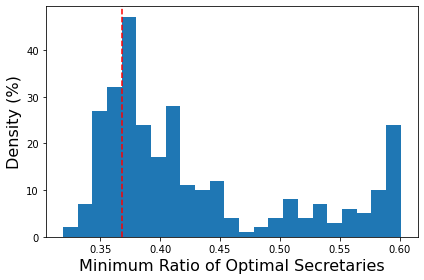

[0.509000000000000, 0.364000000000000, 0.439000000000000, 0.374000000000000, 0.340000000000000, 0.365000000000000, 0.380000000000000, 0.421000000000000, 0.396000000000000, 0.411000000000000, 0.417000000000000, 0.361000000000000, 0.371000000000000, 0.513000000000000, 0.408000000000000, 0.513000000000000, 0.394000000000000, 0.366000000000000, 0.376000000000000, 0.389000000000000, 0.602000000000000, 0.450000000000000, 0.414000000000000, 0.442000000000000, 0.338000000000000, 0.353000000000000, 0.383000000000000, 0.353000000000000, 0.384000000000000, 0.378000000000000, 0.595000000000000, 0.385000000000000, 0.396000000000000, 0.450000000000000, 0.590000000000000, 0.407000000000000, 0.340000000000000, 0.491000000000000, 0.381000000000000, 0.447000000000000, 0.434000000000000, 0.368000000000000, 0.581000000000000, 0.569000000000000, 0.344000000000000, 0.597000000000000, 0.582000000000000, 0.408000000000000, 0.517000000000000, 0.591000000000000, 0.373000000000000, 0.372000000000000, 0.359000000

In [126]:
plot(results)
print(results)

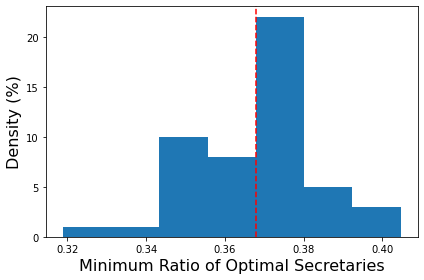

[0.374, 0.371, 0.389, 0.338, 0.353, 0.385, 0.344, 0.373, 0.372, 0.359, 0.375, 0.376, 0.396, 0.368, 0.374, 0.403, 0.359, 0.365, 0.348, 0.386, 0.326, 0.393, 0.354, 0.36, 0.371, 0.373, 0.376, 0.39, 0.351, 0.354, 0.376, 0.372, 0.373, 0.372, 0.354, 0.384, 0.374, 0.405, 0.357, 0.376, 0.346, 0.377, 0.362, 0.368, 0.373, 0.352, 0.351, 0.372, 0.367, 0.36, 0.374]


In [127]:
plot(results_1)
print(results_1)

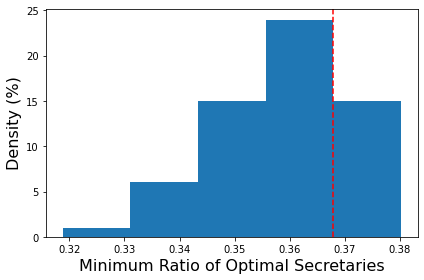

[0.364, 0.34, 0.365, 0.38, 0.361, 0.366, 0.353, 0.34, 0.381, 0.368, 0.356, 0.341, 0.365, 0.364, 0.371, 0.365, 0.365, 0.369, 0.372, 0.333, 0.371, 0.345, 0.354, 0.375, 0.372, 0.364, 0.344, 0.361, 0.387, 0.36, 0.344, 0.347, 0.345, 0.361, 0.374, 0.341, 0.365, 0.372, 0.346, 0.367, 0.347, 0.348, 0.359, 0.351, 0.342, 0.345, 0.36, 0.364, 0.371, 0.389, 0.362, 0.344, 0.356, 0.35, 0.357, 0.378, 0.36, 0.366, 0.331, 0.371, 0.348, 0.363, 0.379, 0.372]


In [132]:
plot(results_2)
print(results_2)

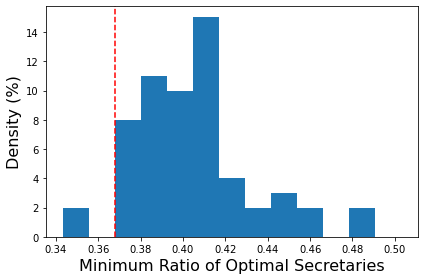

[0.396, 0.411, 0.408, 0.513, 0.376, 0.414, 0.378, 0.447, 0.434, 0.408, 0.393, 0.459, 0.384, 0.374, 0.452, 0.392, 0.398, 0.404, 0.426, 0.411, 0.406, 0.433, 0.378, 0.418, 0.403, 0.405, 0.378, 0.38, 0.396, 0.416, 0.401, 0.407, 0.425, 0.392, 0.405, 0.418, 0.382, 0.381, 0.394, 0.414, 0.387, 0.386, 0.387, 0.406, 0.443, 0.46, 0.483, 0.371, 0.412, 0.353, 0.407, 0.369, 0.404, 0.354, 0.479, 0.392, 0.413, 0.392, 0.392, 0.401]


In [129]:
plot(results_3)
print(results_3)

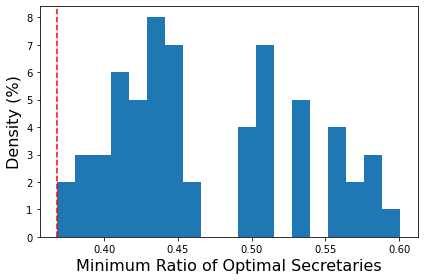

[0.509, 0.439, 0.421, 0.513, 0.384, 0.396, 0.45, 0.491, 0.581, 0.582, 0.46, 0.557, 0.413, 0.427, 0.445, 0.398, 0.504, 0.368, 0.445, 0.387, 0.434, 0.42, 0.533, 0.412, 0.439, 0.538, 0.572, 0.369, 0.505, 0.415, 0.446, 0.501, 0.529, 0.432, 0.438, 0.406, 0.564, 0.58, 0.559, 0.436, 0.494, 0.444, 0.605, 0.382, 0.395, 0.441, 0.443, 0.408, 0.567, 0.511, 0.553, 0.596, 0.505, 0.538, 0.424, 0.447, 0.46, 0.533, 0.5, 0.433, 0.412, 0.508, 0.429]


In [130]:
plot(results_4)
print(results_4)

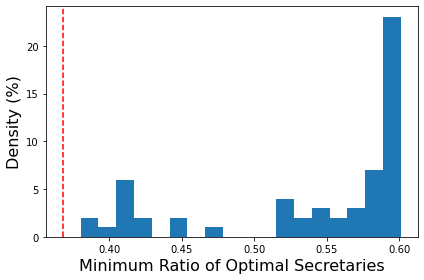

[0.417, 0.394, 0.602, 0.45, 0.442, 0.383, 0.595, 0.59, 0.407, 0.569, 0.597, 0.517, 0.591, 0.419, 0.518, 0.578, 0.562, 0.596, 0.59, 0.583, 0.594, 0.598, 0.579, 0.588, 0.603, 0.548, 0.597, 0.594, 0.598, 0.592, 0.592, 0.519, 0.536, 0.595, 0.408, 0.583, 0.52, 0.382, 0.599, 0.588, 0.541, 0.599, 0.535, 0.574, 0.6, 0.583, 0.414, 0.595, 0.594, 0.604, 0.592, 0.574, 0.605, 0.472, 0.591, 0.543, 0.591, 0.412, 0.406, 0.413, 0.555, 0.597]


In [131]:
plot(results_5)
print(results_5)

In [136]:
min(results)

0.326000000000000

In [ ]:
from math import comb

